In [1]:
%load_ext autoreload
%autoreload 2

In [478]:
import logging

import pandas as pd
import numpy as np
import os
from typing import Union, List, Literal
from datetime import datetime, time, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pickle
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas_ta as ta
from copy import deepcopy

from backtest.utils import calc_date2maturity, calc_time2maturity, plot_legend_outside, get_class_name
from backtest.preprocessors.preprocess import LobTimePreprocessor, LobFeatureEngineering,GeneralTimePreprocessor
from backtest.predefined.macros import LobColTemplate, ColTemplate, CITICSF_ColTemplate
from backtest.statistic_tools.statistics import calc_r_squared, BaseStatistics

from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility
from py_vollib_vectorized.greeks import delta, gamma, vega, theta, rho

root = '/Users/hongyifan/Desktop/work/internship/citic_futures/20231226bid-ask-spread/'
data_root = root + 'data/'
option_data_root = root + 'data/Option/'
future_data_root = root + 'data/Future/'
etf_data_root = root + 'data/ETF/'
res_root = root + 'res/'
model_root = root + 'models/'

etf_future_symbol_dict = {
    '510050.XSHG': 'IH',
    '510300.XSHG': 'IF',
    '510500.XSHG': 'IC',

}

trading_dates = np.array(
    pd.read_csv(data_root + f'trading_dates_cn_2000-01-01_2024-12-31.csv')['trading_dates'].tolist(), dtype=str)

# ltp = LobTimePreprocessor()
tp=GeneralTimePreprocessor()



In [439]:
# macros
TICK_SIZE=0.0001
UPPER_BOUND = 0.001
DECIMALS = 4

# 循环遍历所有合约


In [3]:
# etf价格
etf_price_dict = {}
for udly_symbol in ['510050.XSHG', '510300.XSHG', '510500.XSHG']:
    temp = \
        pd.read_csv(data_root + "ETF/" + f"data_etf_{udly_symbol}_2014-12-01_2023-11-28.csv",
                    usecols=['datetime', 'close'],
                    index_col='datetime', parse_dates=True)['close'].rename('etf_price_' + udly_symbol)
    temp.index = pd.to_datetime(temp.index)
    etf_price_dict[udly_symbol] = temp

In [4]:
# 日度ETF价格
etf_price_dict_daily = {}
for k, v in etf_price_dict.items():
    temp = v.to_frame()
    temp['date'] = pd.to_datetime(v.index).date
    temp = temp.groupby('date').first()
    temp.index = pd.to_datetime(temp.index)
    etf_price_dict_daily[k] = temp

In [5]:
# 无风险利率采用1年期国债收益率
def get_rfr(interest_rate_df, date_, days2maturity):
    idx = np.argmin(abs(interest_rate_df.columns - days2maturity))
    return interest_rate_df.loc[date_].iloc[idx]


interest_rate = pd.read_csv(data_root + f"interest_rate.csv", index_col=0).rename(columns={'ON': 1,  # over night
                                                                                           '1W': 5,
                                                                                           '2W': 10,
                                                                                           '1M': 20,
                                                                                           '3M': 60,
                                                                                           '6M': 120,
                                                                                           '9M': 180,
                                                                                           '1Y': 240}) / 100

In [6]:
# 获取所有日期
dates_list = os.listdir(option_data_root)
dates_list.remove('.DS_Store')
dates_list = sorted(dates_list)
dates_list = pd.to_datetime(dates_list, format='%Y-%m-%d').astype(str).tolist()

In [7]:
# 主函数：遍历所有csv计算iv
option_info_df = pd.read_csv(data_root + 'etf_options_basic_info.csv')
option_info_df['code'] = option_info_df['code'].apply(lambda x: x[:-5])
option_info_df = option_info_df.set_index('code').sort_index()
print("option_info_df 中的expire_date是闭，即到期日为expire_date当天收盘")
rfr = 0.03

option_info_df 中的expire_date是闭，即到期日为expire_date当天收盘
/Users/hongyifan/Desktop/work/internship/citic_futures/20231226bid-ask-spread/data/Option/20230817/


In [115]:
all_expire_date = sorted(option_info_df['expire_date'].unique())

In [9]:
# 遍历所有csv计算factors
fe = LobFeatureEngineering(curr='last', ColFormatter=CITICSF_ColTemplate)
error_dict = defaultdict(dict)
# 加载进度
proc_file_list = sorted(os.listdir(data_root + f"Xy/"))
proc_file_list.remove('.DS_Store')
proc_file_list = np.array(proc_file_list)
proc_date_list = sorted([x[-14:-4] for x in proc_file_list])
proc_date_list = np.array(proc_date_list)
unproc_date_list = np.array(sorted(list(set(dates_list) - set(proc_date_list))))
# with open(data_root+'Xy/Xy.pkl','rb') as fw:
#     Xy_dict=pickle.load(fw)
#     print(f"already processed untill {list(Xy_dict.keys())[-1]}")

print("option_info_df 中的expire_date是闭，即到期日为expire_date当天收盘")
rfr = 0.03
option_underlying_symbol_list = ['510050.csv', '510300.csv', '510500.csv']

option_info_df 中的expire_date是闭，即到期日为expire_date当天收盘


# 数据

In [10]:
train_start = '2023-08-24'
train_end = '2023-09-27'
valid_start = '2023-09-28'
valid_end = '2023-10-25'
test_start = valid_start
test_end = valid_end

In [11]:
class DataKey(object):
    def __init__(self, option_symbol=None, trading_code=None, ttm_type=None, option_type=None, strike=None):
        raise DeprecationWarning()
        self.option_symbol = str(option_symbol) if option_symbol is not None else None
        self.trading_code = str(trading_code) if trading_code is not None else None
        self.ttm_type = int(ttm_type) if ttm_type is not None else None
        self.option_type = str(option_type) if option_type is not None else None
        self.strike = float(strike) if strike is not None else None

    def __eq__(self, another):
        # res=True
        flags = []
        flags.append(hasattr(another, 'option_symbol'))
        flags.append(hasattr(another, 'trading_code'))
        flags.append(hasattr(another, 'ttm_type'))
        flags.append(hasattr(another, 'option_type'))
        flags.append(hasattr(another, 'strike'))
        # res=res and np.array(flags).all()
        # flags=[]
        if self.option_symbol is not None and another.option_symbol is not None:
            flags.append(self.option_symbol == another.option_symbol)
        if self.trading_code is not None and another.trading_code is not None:
            flags.append(self.trading_code == another.trading_code)
        if self.ttm_type is not None and another.ttm_type is not None:
            flags.append(self.ttm_type == another.ttm_type)
        if self.option_type is not None and another.option_type is not None:
            flags.append(self.option_type == another.option_type)
        if self.strike is not None and another.strike is not None:
            flags.append(self.strike == another.strike)
        return np.array(flags).all()

    def __hash__(self):
        h = 0
        if self.option_symbol is not None:
            h += hash(self.option_symbol)
        if self.trading_code is not None:
            h += hash(self.trading_code)
        if self.ttm_type is not None:
            h += hash(self.ttm_type)
        if self.option_type is not None:
            h += hash(self.option_type)
        if self.strike is not None:
            h += hash(self.strike)
        return hash((self.option_symbol, self.trading_code, self.ttm_type, self.option_type, self.strike))

    def __repr__(self):
        return str((self.option_symbol,
                    self.trading_code,
                    self.ttm_type,
                    self.option_type,
                    self.strike))

In [12]:
class DataFetcher(object):
    def __init__(self, Xy_dict):
        self.Xy_dict = Xy_dict
        self.keys = np.array(list(self.Xy_dict.keys()))
        self.__init_idx__()

    def __init_idx__(self):
        keys = self.keys

        self.idx_option_symbol = np.array([k[0] for k in keys], dtype=str)
        self.idx_trading_code = np.array([k[1] for k in keys], dtype=str)
        self.idx_ttm_type = np.array([k[2] for k in keys], dtype=int)  # 到期类型，当月下月两个季月 1,2,3,6
        self.idx_option_type = np.array(['c' if k[3] == 'CO' else 'p' for k in keys], dtype=str)  # c/p
        self.idx_strike = np.array([k[4] for k in keys], dtype=float)

    def __len__(self):
        return len(self.keys)

    def by_all_and(self, option_symbol=None, trading_code=None, ttm_type=None, option_type=None, strike=None) -> dict:
        assert not (
                option_symbol is None and trading_code is None and ttm_type is None and option_type is None and strike is None)
        idx = np.full(shape=(self.__len__()), fill_value=True, dtype=bool)
        if option_symbol is not None:
            idx = np.logical_and(idx, self.idx_option_symbol == option_symbol)
        if trading_code is not None:
            idx = np.logical_and(idx, self.idx_trading_code == trading_code)
        if ttm_type is not None:
            idx = np.logical_and(idx, self.idx_ttm_type == ttm_type)
        if option_type is not None:
            idx = np.logical_and(idx, self.idx_option_type == option_type)
        if strike is not None:
            idx = np.logical_and(idx, self.idx_strike == strike)
        idx = np.array(list(range(self.__len__())))[idx]
        keys = self.keys[idx]
        if len(keys) == 0:
            return {}

        return {(k[0], k[1], int(k[2]), k[3], float(k[4])): self.Xy_dict[(k[0], k[1], int(k[2]), k[3], float(k[4]))] for
                k in keys}


In [264]:
# option_trading_code
def get_option_life(option_trading_code) -> dict:
    """获取一个期权整个生命周期，
    
    Parameters
    ----------
    option_trading_code : 

    Returns
    -------
    dict, key内包含了ttm的type，即当月下月两个季月
        
    """
    proc_months = [x[-12:-10] + x[-9:-7] for x in proc_file_list]
    # print("proc_months",proc_months)
    idx = option_trading_code[7:11] >= np.array(proc_months)
    # print(proc_file_list[idx])
    df = defaultdict(list)
    for file_name in proc_file_list[idx]:
        # print(file_name)
        with open(f"{data_root}Xy/{file_name}", 'rb') as fr:
            Xy_dict = pickle.load(fr)
        fetcher = DataFetcher(Xy_dict)
        temp = fetcher.by_all_and(trading_code=option_trading_code)
        if len(temp) == 0:
            continue
        for k, v in temp.items():
            df[k].append(v)

    res = {}
    for k, v in df.items():
        t = pd.concat(v, axis=0)
        t.index = pd.to_datetime(t.index)
        t = t.sort_index().ffill()
        res[k] = t
    return res


def get_contract(expire_date: str = None, option_type: Literal['c', 'p', 'CO', 'PO'] = None, strike: float = None,
                 underlying_symbol: str = None):
    """挑选一个需要的合约
    
    Parameters
    ----------
    expire_date : 
    option_type : 
    strike : 

    Returns
    -------

    """
    idx = np.full(shape=(len(option_info_df)), fill_value=True, dtype=bool)
    if expire_date is not None:
        idx = np.logical_and(idx, option_info_df['expire_date'] == expire_date)
    if option_type is not None:
        if option_type == 'c': option_type = 'CO'
        if option_type == 'p': option_type = 'PO'
        idx = np.logical_and(idx, option_info_df['contract_type'] == option_type)
    if strike is not None:
        idx = np.logical_and(idx, option_info_df['exercise_price'] == strike)
    if underlying_symbol is not None:
        idx = np.logical_and(idx, option_info_df['underlying_symbol'] == underlying_symbol)
    return option_info_df.loc[idx]


def get_key(keys, ttm_type=None, option_type=None, strike=None):
    """从很多key中挑出符合条件的key。现阶段仅仅ttm_type可能存在不同
    
    Parameters
    ----------
    keys : dict_keys,
        

    Returns
    -------

    """
    if ttm_type is not None:
        assert ttm_type in [1, 2, 3, 6, '1', '2', '3', '6']
        idx = np.array(range(len(keys)))[np.array([k[2] for k in list(keys)]) == ttm_type]
        assert len(idx) == 1
        idx = idx[0]
        return list(keys)[idx]
    if option_type is not None:
        raise NotImplementedError()
    if strike is not None:
        raise NotImplementedError()



In [446]:
# 挑选一个合约
get_contract(expire_date=train_end)

True


,trading_code,name,contract_type,exchange_code,currency_id,underlying_symbol,underlying_name,underlying_exchange,underlying_type,exercise_price,...,list_price,high_limit,low_limit,expire_date,last_trade_date,exercise_date,delivery_date,is_adjust,delist_date,delist_reason
code,,,,,,,,,,,,,,,,,,,,,
10005105,510050C2309M02650,50ETF购9月2650,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.65,...,0.3160,0.6009,0.0311,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
10005106,510050C2309M02700,50ETF购9月2700,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.70,...,0.2793,0.5642,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
10005107,510050C2309M02750,50ETF购9月2750,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.75,...,0.2506,0.5355,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
10005108,510050C2309M02800,50ETF购9月2800,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.80,...,0.2228,0.5077,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
10005109,510050C2309M02850,50ETF购9月2850,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.85,...,0.1967,0.4815,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90002630,159915P2309M001750,创业板ETF沽9月1750,PO,XSHE,CNY,159915.XSHE,易方达创业板ETF,XSHE,ETF,1.75,...,0.0002,0.3054,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
90002637,159901C2309M002400,深证100ETF购9月2400,CO,XSHE,CNY,159901.XSHE,易方达深证100ETF,XSHE,ETF,2.40,...,0.2197,0.4815,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期
90002638,159901P2309M002400,深证100ETF沽9月2400,PO,XSHE,CNY,159901.XSHE,易方达深证100ETF,XSHE,ETF,2.40,...,0.0001,0.2183,0.0001,2023-09-27,2023-09-27,2023-09-27,2023-09-28,0,2023-09-28,合约到期


In [467]:
get_contract(expire_date=test_end)

True


,trading_code,name,contract_type,exchange_code,currency_id,underlying_symbol,underlying_name,underlying_exchange,underlying_type,exercise_price,...,list_price,high_limit,low_limit,expire_date,last_trade_date,exercise_date,delivery_date,is_adjust,delist_date,delist_reason
code,,,,,,,,,,,,,,,,,,,,,
10005913,510050C2310M02350,50ETF购10月2350,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.35,...,0.2152,0.4687,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005914,510050C2310M02400,50ETF购10月2400,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.40,...,0.1739,0.4274,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005915,510050C2310M02450,50ETF购10月2450,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.45,...,0.1379,0.3914,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005916,510050C2310M02500,50ETF购10月2500,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.50,...,0.1051,0.3586,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005917,510050C2310M02550,50ETF购10月2550,CO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.55,...,0.0792,0.3312,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90002772,159901P2310M002250,深证100ETF沽10月2250,PO,XSHE,CNY,159901.XSHE,易方达深证100ETF,XSHE,ETF,2.25,...,0.0001,0.2035,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
90002779,159915C2310M001600,创业板ETF购10月1600,CO,XSHE,CNY,159915.XSHE,易方达创业板ETF,XSHE,ETF,1.60,...,0.2154,0.5784,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
90002780,159915P2310M001600,创业板ETF沽10月1600,PO,XSHE,CNY,159915.XSHE,易方达创业板ETF,XSHE,ETF,1.60,...,0.0001,0.2771,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期


# 回归

In [271]:
def round2tick(series, tick_decimals=DECIMALS):
    res = series.round(decimals=tick_decimals)
    idx = res <= 0
    res[idx] = 0.1 ** tick_decimals
    return res.round(decimals=tick_decimals)


class SpreadStatistics(BaseStatistics):
    def gen_stat(self, y_true, y_pred, *args, **kwargs):
        res = {}
        res['acc'] = ((y_true - round2tick(y_pred)).round(decimals=DECIMALS) == 0).mean()
        res['SSE'] = ((y_true - y_pred) ** 2).sum()
        res['SSE_rounded'] = ((y_true - y_pred.round(decimals=DECIMALS)) ** 2).sum()
        res['r2'] = calc_r_squared(y_true, y_pred)

        return res

    def myplot(self, y_true, y_pred, name='', title=None, plot_tick_mid=False):
        if len(name) > 0:
            name = 'y_true' + f"_{name}"
        else:
            name = 'y_true'
        res = y_true.to_frame(name=name)
        res['y_pred'] = y_pred
        tick_mid = None
        if plot_tick_mid:
            tick_mid = np.array(sorted(np.unique(res.values.flatten().round(decimals=DECIMALS))), dtype=float)
            tick_mid = (tick_mid[1:] + tick_mid[:-1]) / 2
        plot_legend_outside(res, title=title, marker='.', linestyle='', horizontal_line_values=tick_mid)

    def plot_all(self, y_true, y_pred, name, window=10, smooth=False):
        self.myplot(y_true, y_pred, title=f'{name}', plot_tick_mid=True)
        if smooth:
            self.myplot(y_true, ta.ema(y_pred, length=window, talib=False), title=f'{name}_EMA_tick',
                        plot_tick_mid=True)

        # self.myplot(y_true, round2tick(y_pred), title=f'{name}_tick',plot_tick_mid=False)
        # self.myplot(y_true, round2tick(talib.MA(y_pred, timeperiod=window)), title=f'{name}_MA_tick',plot_tick_mid=False)
        # self.myplot(y_true, round2tick(talib.EMA(y_pred, timeperiod=window)), title=f'{name}_EMA_tick',plot_tick_mid=False)


ss = SpreadStatistics()

## OLS - monthly pairs

In [14]:
# 两个ATM call 期权一个月的数据分别作为train和test
option_trading_code_train = '510050C2309M02850'
Xy_train = get_option_life(option_trading_code_train)
option_trading_code_test = '510050C2310M02550'
Xy_test = get_option_life(option_trading_code_test)


In [16]:
ttm_type = 1
y_col = 'spread'
exclude = [y_col, 'spread_syn', 'time2maturity', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'moneyness']


In [59]:
# train data
temp = Xy_train[get_key(Xy_train.keys(), ttm_type=ttm_type)]
# temp=temp.loc[str(sorted(list(set(temp.index.date)))[date_idx])]

# X_train=temp.drop(columns=[y_col,])
X_train = temp.drop(columns=exclude)
# X_train=temp['delta']

X_train = sm.add_constant(X_train, has_constant='skip')
y_train = temp[y_col]


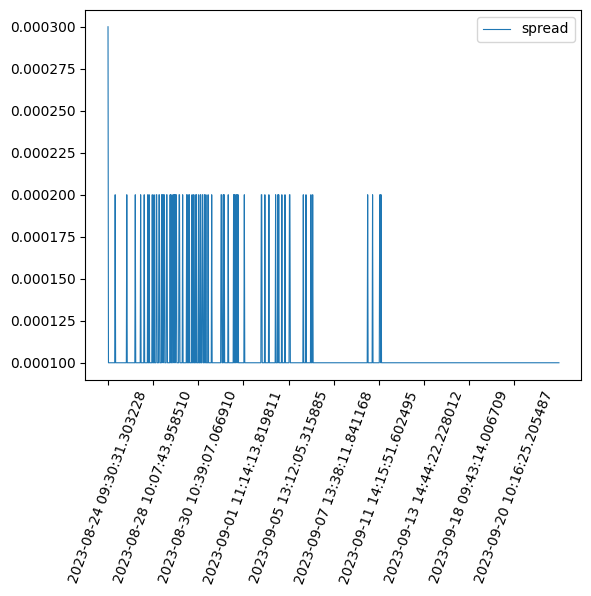

In [60]:
plot_legend_outside(y_train)

In [61]:
# test data
temp = Xy_test[get_key(Xy_test.keys(), ttm_type=ttm_type)]
# temp=temp.loc[str(sorted(list(set(temp.index.date)))[date_idx])]


# X_test=temp.drop(columns=[y_col,])
X_test = temp.drop(columns=exclude)
# X_test=temp['delta']

X_test = sm.add_constant(X_test, has_constant='skip')
y_test = temp[y_col]

In [63]:
# note: test和train对齐
usecols = sorted(list(set(X_train.columns).intersection(set(X_test.columns))))
X_train = X_train.loc[:, usecols]
X_test = X_test.loc[:, usecols]

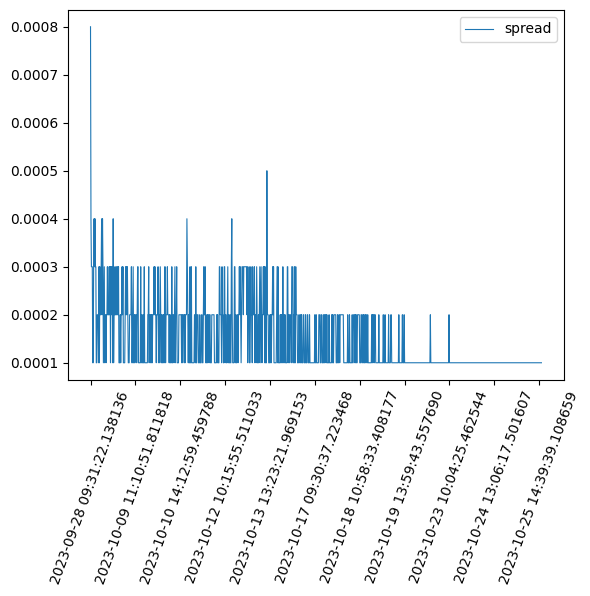

In [62]:
plot_legend_outside(y_test)

In [64]:
model = OLS(y_train, exog=X_train, missing='drop')
results = model.fit()
y_pred_train = model.predict(params=results.params, exog=X_train)
y_pred_test = model.predict(params=results.params, exog=X_test)

In [65]:
print("has const", results.summary())

has const                             OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     1154.
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:29:19   Log-Likelihood:             8.9211e+05
No. Observations:               97923   AIC:                        -1.784e+06
Df Residuals:                   97913   BIC:                        -1.784e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
IV                    

/Users/hongyifan/miniconda3/envs/ML_py310/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


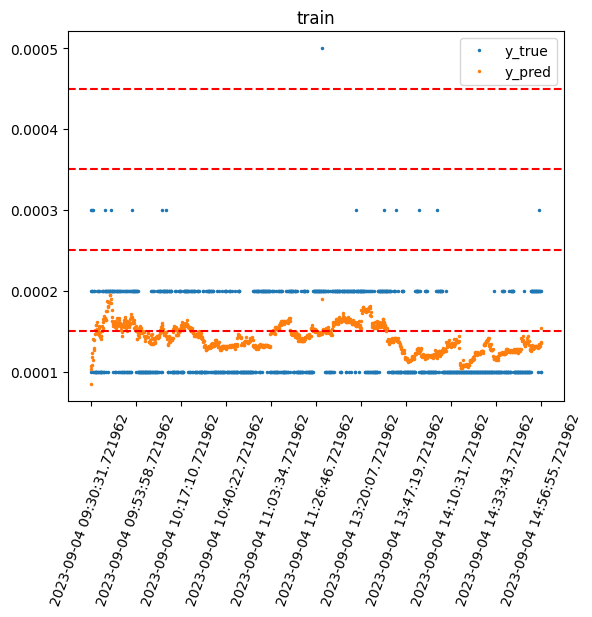

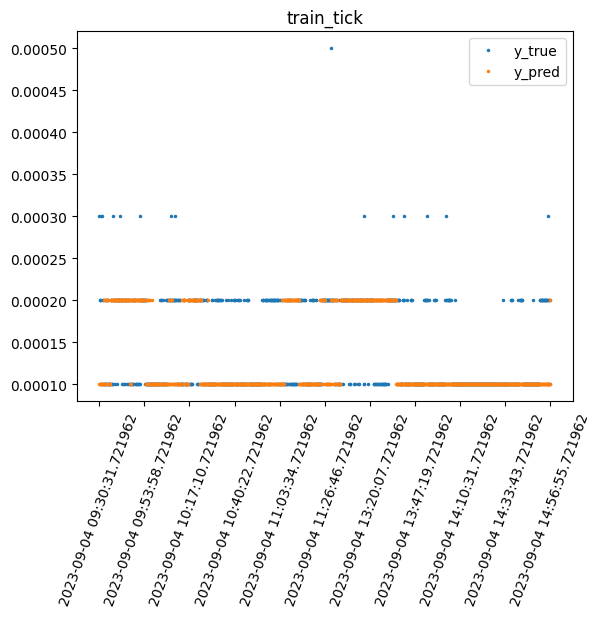

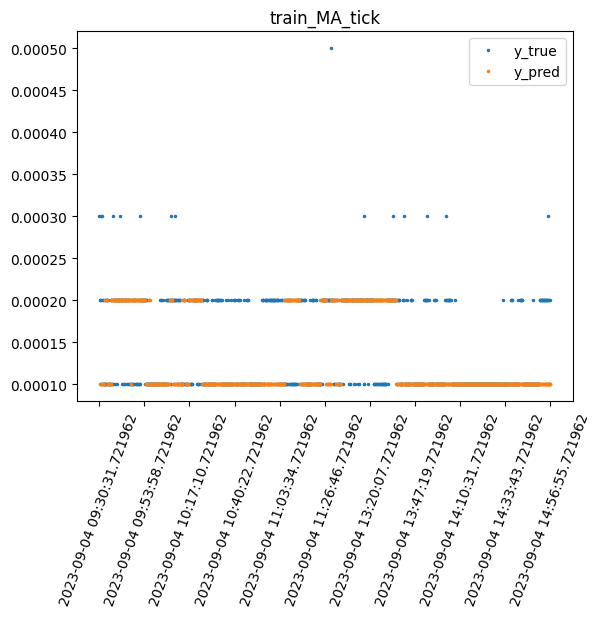

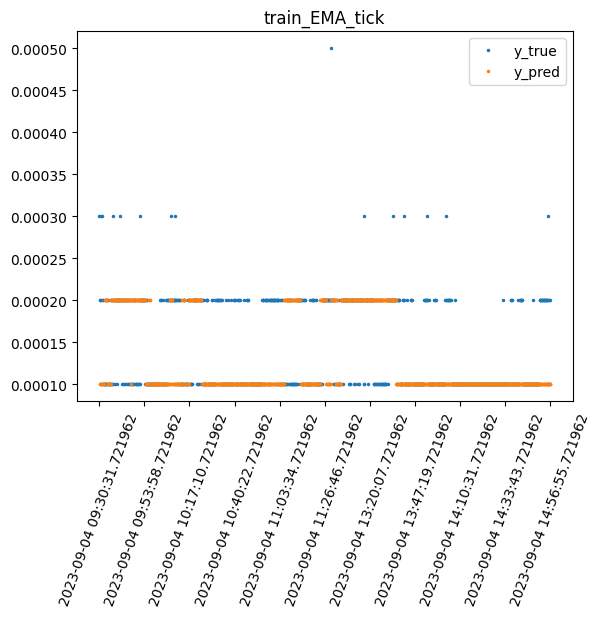

{'acc': 0.6727703576044808,
 'SSE': 1.1363139484417756e-05,
 'SSE_rounded': 1.6300000000000037e-05,
 'r2': 0.0982424706079631}

In [199]:
ss.plot_all(y_train, y_pred_train, name='train', window=10)
ss.gen_stat(y_train, y_pred_train)

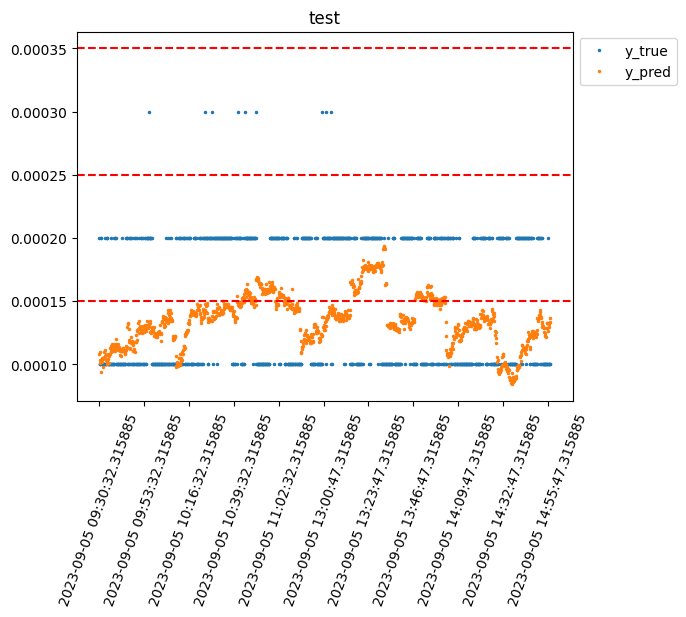

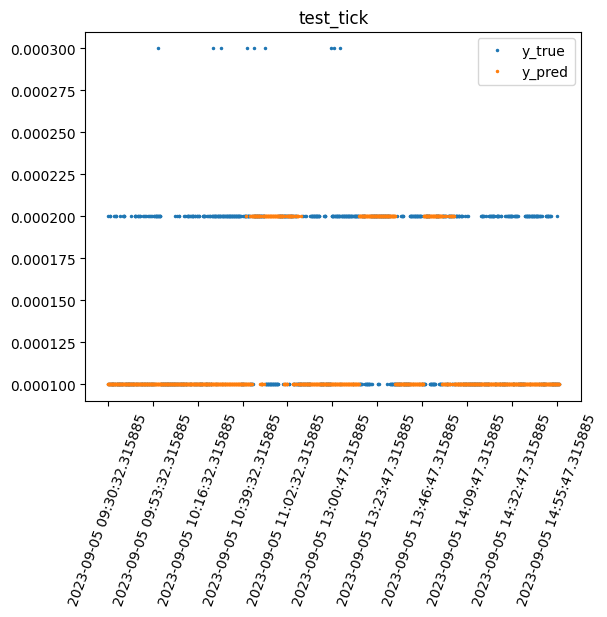

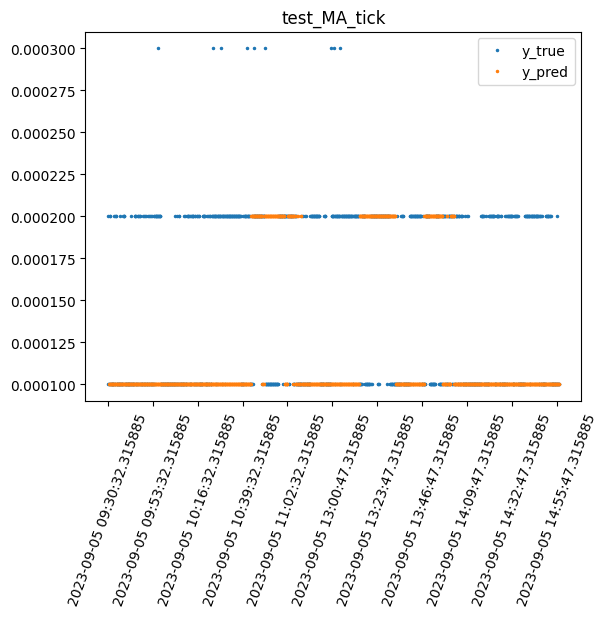

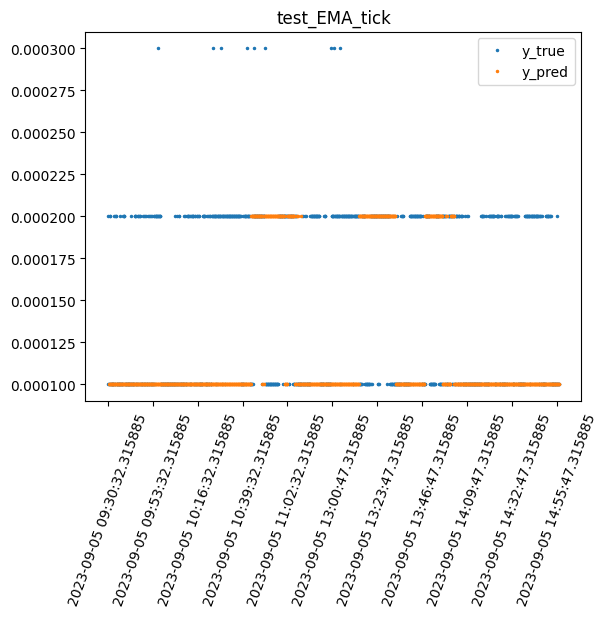

{'acc': 0.5102702702702703,
 'SSE': 1.393001734367207e-05,
 'SSE_rounded': 2.3570000000000027e-05,
 'r2': -0.13074791949282094}

In [198]:
ss.plot_all(y_test, y_pred_test, name='test', window=10)
ss.gen_stat(y_test, y_pred_test)

In [432]:

pd.concat([X_train.describe(), X_test.describe()], axis=0)

,const,IV,delta,moneyness_squared,moneyness_t2m,moneyness_delta,mid_quoted_price,etf_quoted_spread,future_quoted_spread,is_opening_period,opening_decreasing,avg_duration
count,382.0,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.0,382.0,382.000000
mean,1.0,0.380633,0.012914,0.005873,-0.000614,-0.000987,0.000555,0.000267,0.000097,0.0,0.0,7.096190
std,0.0,0.006196,0.001722,0.000284,0.000008,0.000112,0.000090,0.000030,0.000049,0.0,0.0,3.809960
min,1.0,0.368085,0.010921,0.005406,-0.000630,-0.001359,0.000450,0.000263,0.000053,0.0,-0.0,0.503553
25%,1.0,0.376468,0.011177,0.005607,-0.000622,-0.001091,0.000450,0.000263,0.000054,0.0,0.0,4.185065
50%,1.0,0.381691,0.012640,0.005800,-0.000611,-0.000959,0.000550,0.000263,0.000107,0.0,-0.0,6.148835
75%,1.0,0.385222,0.013971,0.006161,-0.000607,-0.000876,0.000650,0.000264,0.000107,0.0,-0.0,9.902337
max,1.0,0.395074,0.018223,0.006323,-0.000601,-0.000861,0.000850,0.000528,0.000374,0.0,-0.0,18.249403
count,4368.0,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.0,4368.0,4368.000000
mean,1.0,0.947796,0.003198,0.006680,-0.000082,-0.000263,0.000067,0.000270,0.000099,0.0,0.0,34.756372


## OLS - daily pairs

今天t用上个月到期的具有相同ttm(T-t)的同moneyness、c/p作为train

In [14]:
# 两个ATM call 期权一个月的数据分别作为train和test
option_trading_code_train = '510050C2309M02850'
Xy_train = get_option_life(option_trading_code_train)
option_trading_code_test = '510050C2310M02550'
Xy_test = get_option_life(option_trading_code_test)


In [16]:
ttm_type = 1
y_col = 'spread'
exclude = [y_col, 'spread_syn', 'time2maturity', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'moneyness']


In [77]:
date_idx = -5  # 距离到期日前n天

In [78]:
# train data
temp = Xy_train[get_key(Xy_train.keys(), ttm_type=ttm_type)]
temp = temp.loc[str(sorted(list(set(temp.index.date)))[date_idx])]

# X_train=temp.drop(columns=[y_col,])
X_train = temp.drop(columns=exclude)
# X_train=temp['delta']

X_train = sm.add_constant(X_train, has_constant='skip')
y_train = temp[y_col]


In [80]:
# test data
temp = Xy_test[get_key(Xy_test.keys(), ttm_type=ttm_type)]
temp = temp.loc[str(sorted(list(set(temp.index.date)))[date_idx])]

# X_test=temp.drop(columns=[y_col,])
X_test = temp.drop(columns=exclude)
# X_test=temp['delta']

X_test = sm.add_constant(X_test, has_constant='skip')
y_test = temp[y_col]

In [82]:
# note: test和train对齐
usecols = sorted(list(set(X_train.columns).intersection(set(X_test.columns))))
X_train = X_train.loc[:, usecols]
X_test = X_test.loc[:, usecols]

In [83]:
model = OLS(y_train, exog=X_train, missing='drop')
results = model.fit()
y_pred_train = model.predict(params=results.params, exog=X_train)
y_pred_test = model.predict(params=results.params, exog=X_test)

In [84]:
print("has const", results.summary())

has const                             OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.492
Date:                Tue, 09 Jan 2024   Prob (F-statistic):            0.00773
Time:                        17:37:09   Log-Likelihood:                 53662.
No. Observations:                4473   AIC:                        -1.073e+05
Df Residuals:                    4463   BIC:                        -1.072e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
IV                    

/Users/hongyifan/miniconda3/envs/ML_py310/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


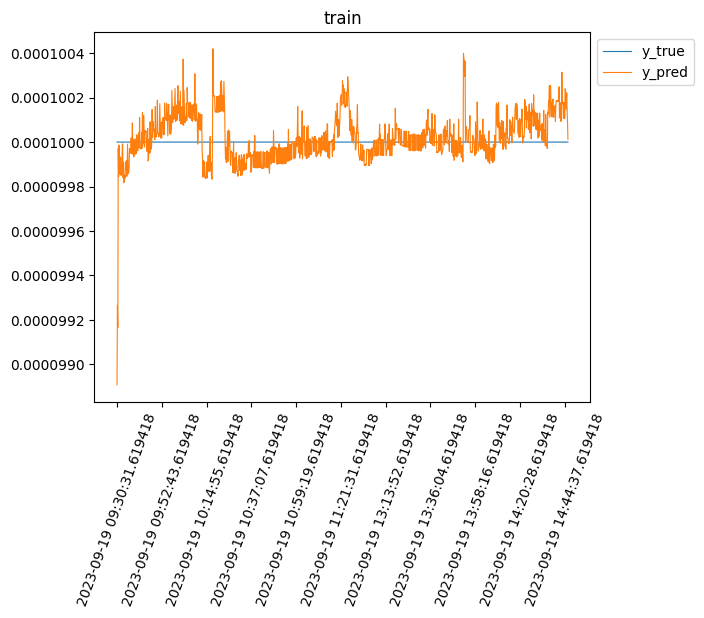

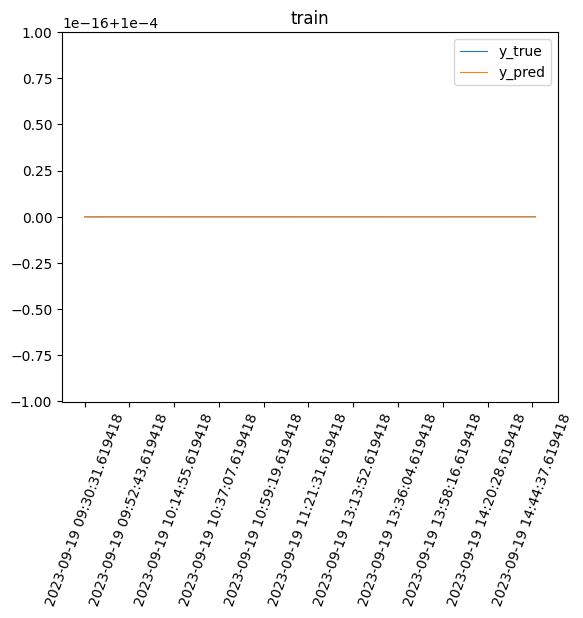

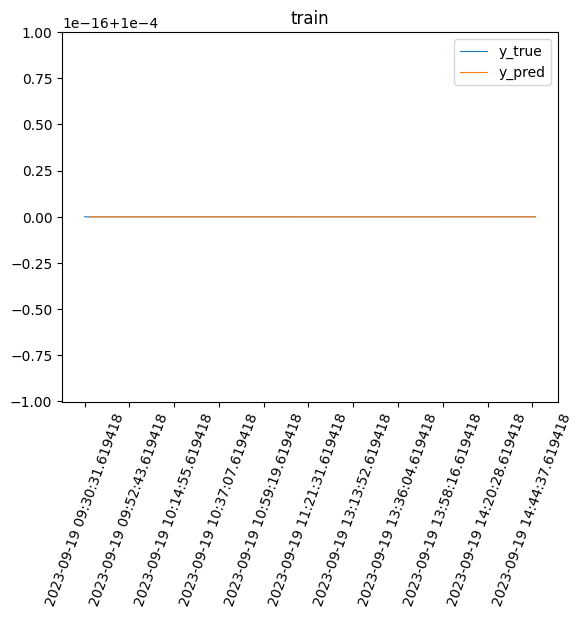

In [86]:
ss.plot_all(y_train, y_pred_train, name='train', window=10)
ss.gen_stat(y_train, y_pred_train)

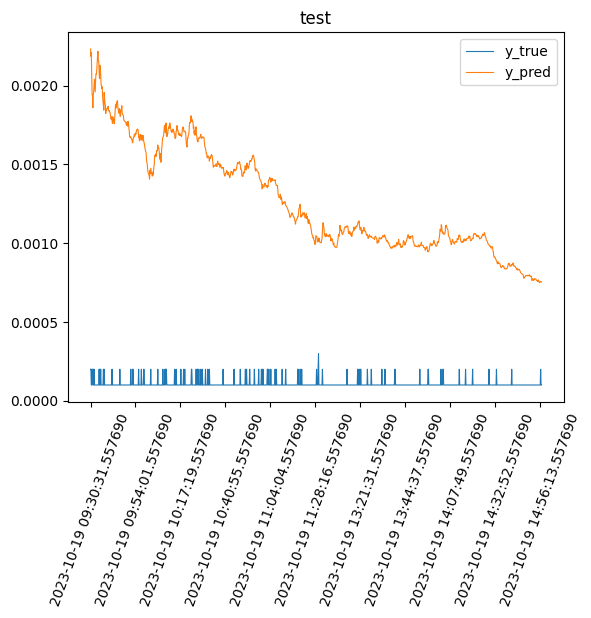

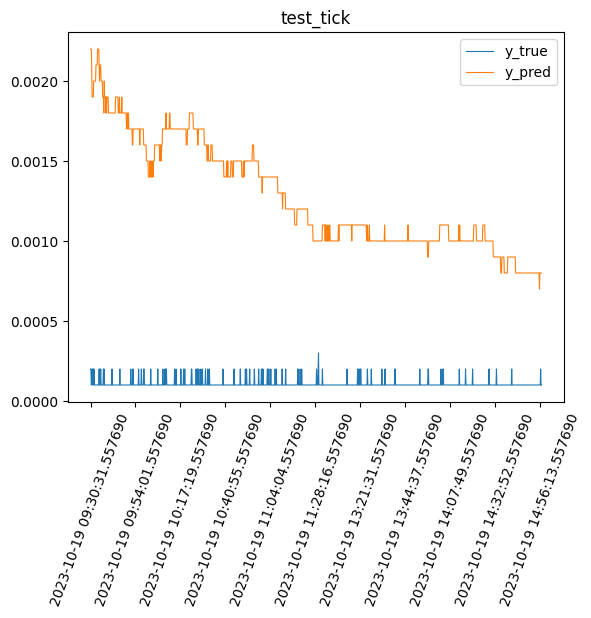

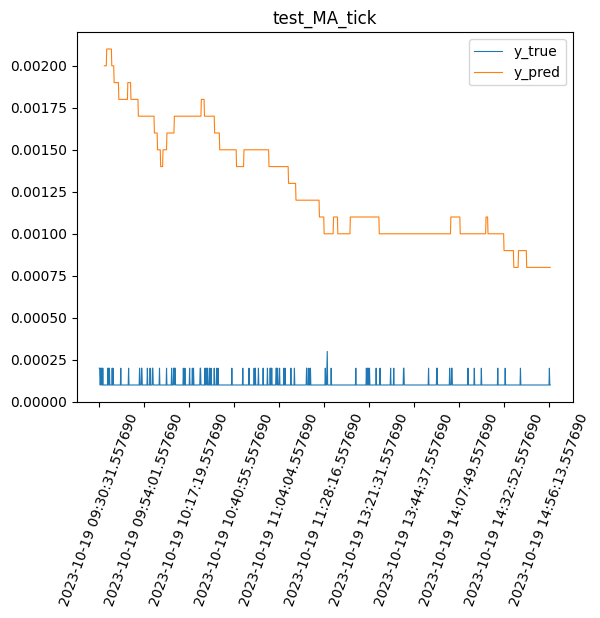

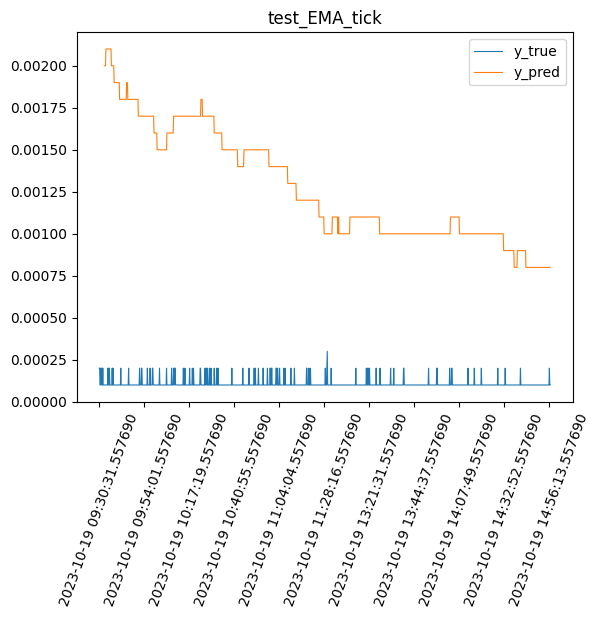

In [87]:
ss.plot_all(y_test, y_pred_test, name='test', window=10)
ss.gen_stat(y_test, y_pred_test)

## OLS - monthly pairs, inverse y

In [414]:
def sigmoid_inverse(y, scale=UPPER_BOUND):
    """
        
    Parameters
    ----------
    y : 
    scale : 

    .. :math:
        y=scale * \frac{1}{1+e^{-x}}
    """
    y = y / scale
    return np.log(y / (1 - y))


def sigmoid(x, scale=UPPER_BOUND):
    return scale / (1 + np.exp(-x))

In [415]:
scale = max(y_train) + TICK_SIZE
y_train = sigmoid_inverse(y_train, scale=scale)

In [416]:
model = OLS(y_train, exog=X_train, missing='drop')
results = model.fit()
# y_test = y_test.to_frame(name='y_test_true')
y_pred_train = model.predict(params=results.params, exog=X_train)
y_pred_train = sigmoid(y_pred_train)
y_train = sigmoid(y_train, scale=scale)

y_pred_test = model.predict(params=results.params, exog=X_test)
y_pred_test = sigmoid(y_pred_test)

In [417]:
print("has const", results.summary())

has const                             OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     2370.
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:31:39   Log-Likelihood:                -44010.
No. Observations:               98320   AIC:                         8.804e+04
Df Residuals:                   98310   BIC:                         8.813e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

/Users/hongyifan/miniconda3/envs/ML_py310/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


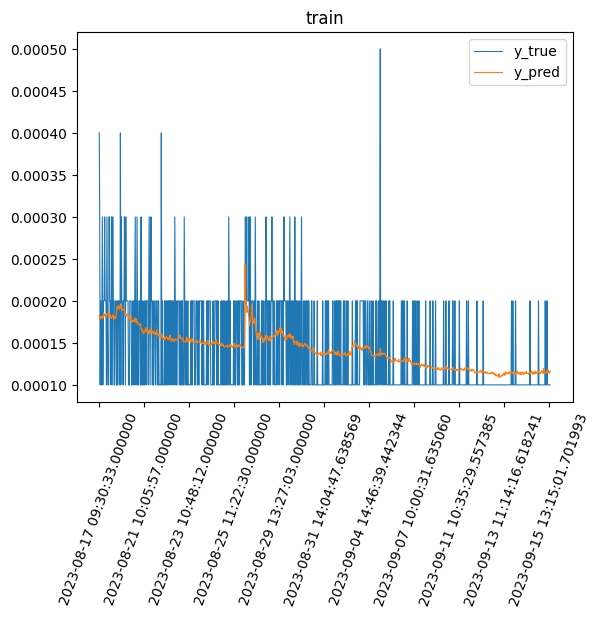

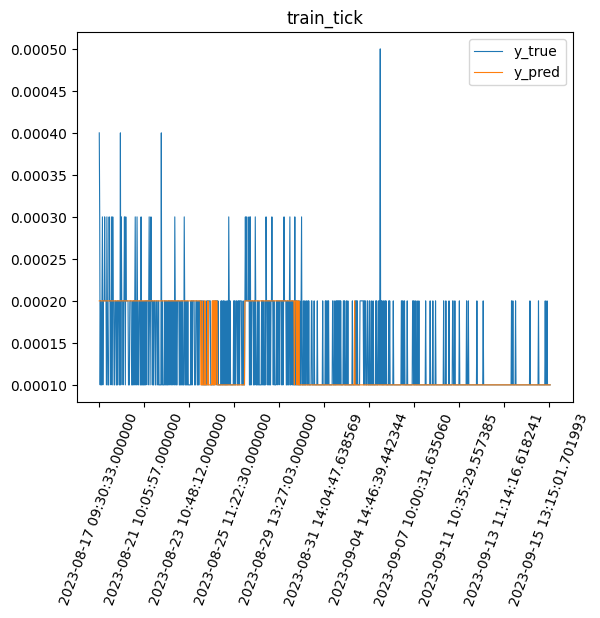

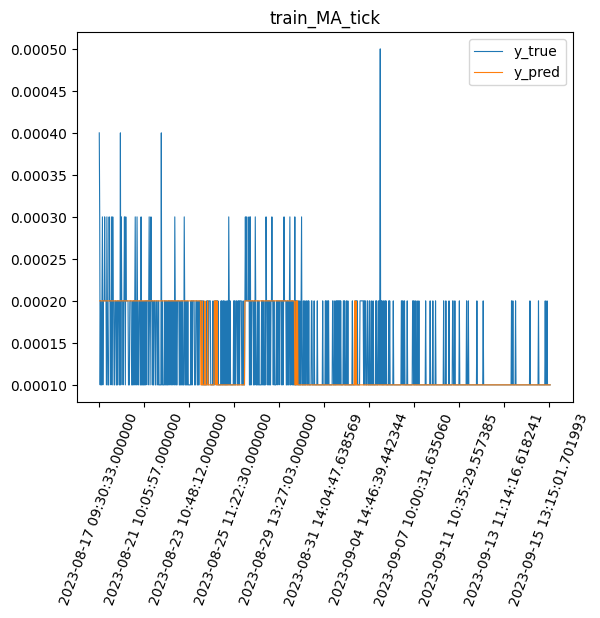

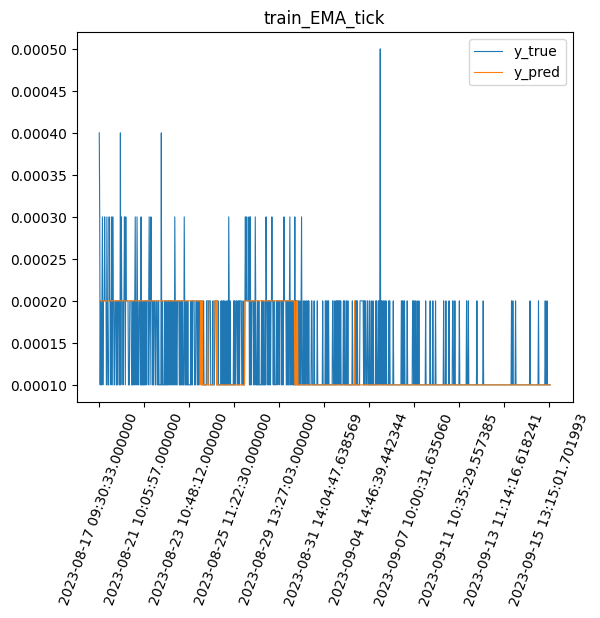

In [421]:
ss.plot_all(y_train, y_pred_train, name='train', window=10)
ss.gen_stat(y_train, y_pred_train)

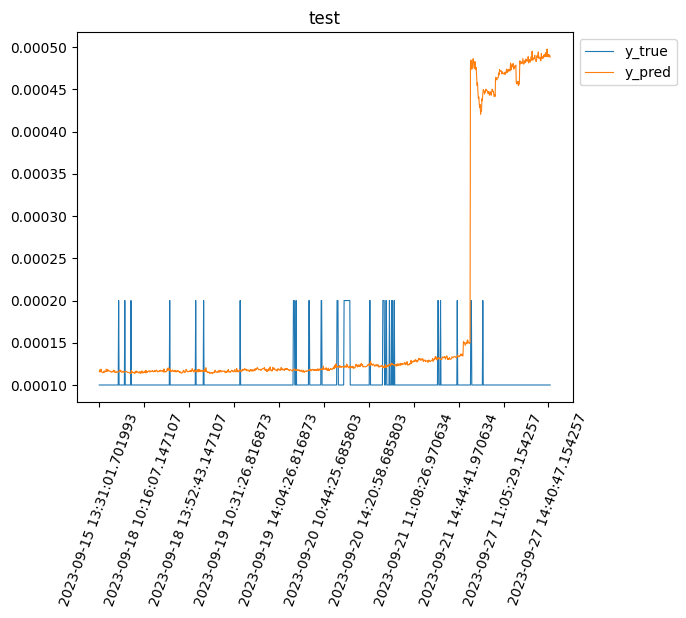

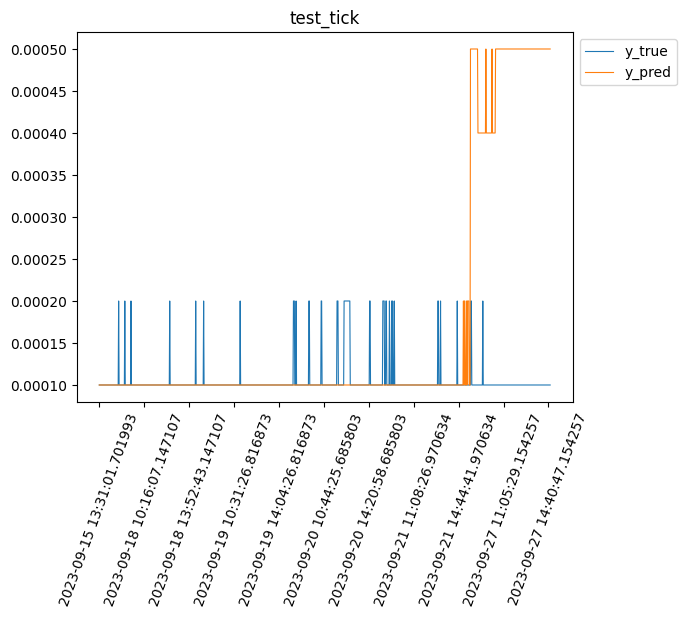

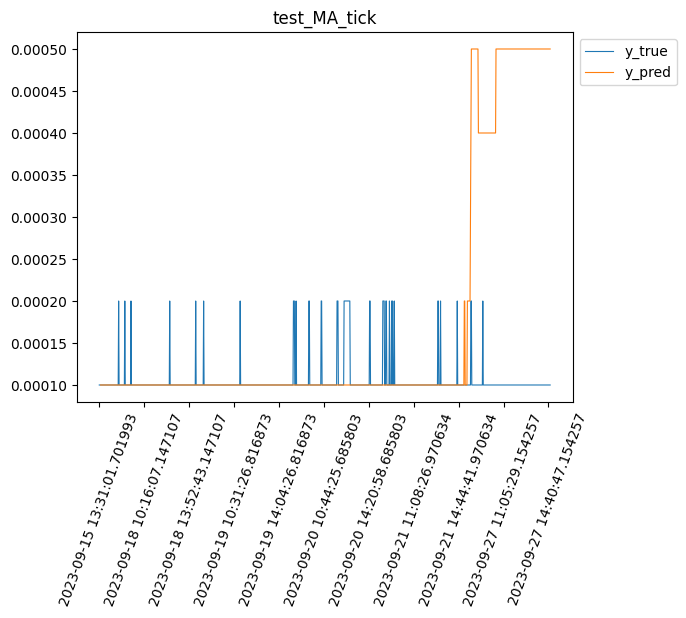

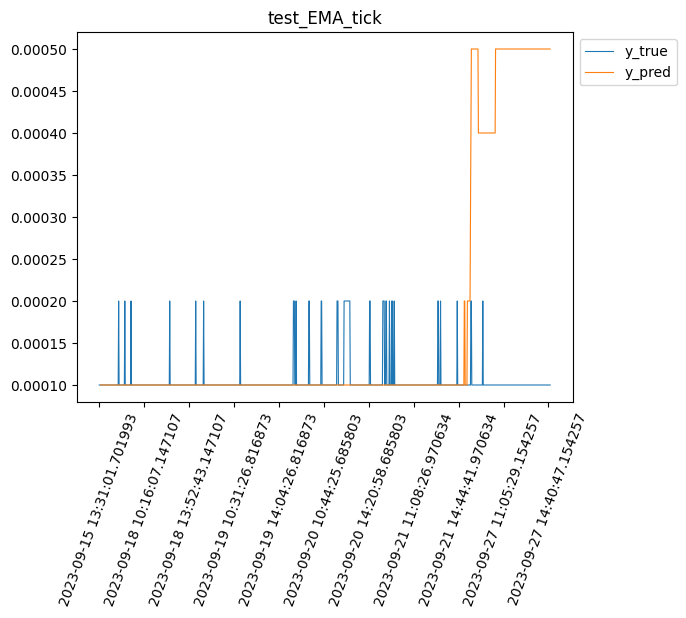

In [420]:
ss.plot_all(y_test, y_pred_test, name='test', window=10)
ss.gen_stat(y_test, y_pred_test)

## OLS - daily rolling

需要注意不能用距离到期日过近的数据，因为theta变化极快

### data

In [116]:
all_expire_date

['2023-01-30',
 '2023-02-22',
 '2023-03-22',
 '2023-04-26',
 '2023-05-24',
 '2023-06-28',
 '2023-07-26',
 '2023-08-23',
 '2023-09-27',
 '2023-10-25',
 '2023-11-22',
 '2023-12-27',
 '2024-01-24',
 '2024-03-27',
 '2024-06-26']

In [118]:
get_contract(expire_date='2023-10-25', option_type='p', strike=2.45)

,trading_code,name,contract_type,exchange_code,currency_id,underlying_symbol,underlying_name,underlying_exchange,underlying_type,exercise_price,...,list_price,high_limit,low_limit,expire_date,last_trade_date,exercise_date,delivery_date,is_adjust,delist_date,delist_reason
code,,,,,,,,,,,,,,,,,,,,,
10005924,510050P2310M02450,50ETF沽10月2450,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.45,...,0.0381,0.2746,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
90002528,159901P2310M002450,深证100ETF沽10月2450,PO,XSHE,CNY,159901.XSHE,易方达深证100ETF,XSHE,ETF,2.45,...,0.0110,0.2336,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期


In [219]:
# 某个期权的数据前后各一天分别作为train和test
option_trading_code = '510050P2310M02450'
Xy = get_option_life(option_trading_code)
Xy.keys()

dict_keys([('10005924', '510050P2310M02450', 2, 'PO', 2.45), ('10005924', '510050P2310M02450', 1, 'PO', 2.45)])

In [220]:
Xy = pd.concat(list(Xy.values()), axis=0).sort_index()
Xy=tp.del_untrade_time_(Xy,use_default=True)

In [121]:
ttm_type = 1
y_col = 'spread'
exclude = [y_col, 'spread_syn', 'time2maturity', 'gamma', 'vega', 'theta', 'rho', 'avg_volume_diff', 'moneyness']
date_idx = -30  # 距离到期日前n天

In [140]:
# train data
temp = deepcopy(Xy.loc[str(sorted(list(set(Xy.index.date)))[date_idx])])

# X_train=temp.drop(columns=[y_col,])
X_train = temp.drop(columns=exclude)
# X_train=temp['delta']

X_train = sm.add_constant(X_train, has_constant='skip')
y_train = temp[y_col]


In [141]:
# test data
temp = deepcopy(Xy.loc[str(sorted(list(set(Xy.index.date)))[date_idx + 1])])

# X_test=temp.drop(columns=[y_col,])
X_test = temp.drop(columns=exclude)
# X_test=temp['delta']

X_test = sm.add_constant(X_test, has_constant='skip')
y_test = temp[y_col]


In [142]:
# note: test和train对齐
usecols = sorted(list(set(X_train.columns).intersection(set(X_test.columns))))
X_train = X_train.loc[:, usecols]
X_test = X_test.loc[:, usecols]

In [202]:
model = OLS(y_train, exog=X_train, missing='drop')
results = model.fit()
y_pred_train = model.predict(params=results.params, exog=X_train)
y_pred_test = model.predict(params=results.params, exog=X_test)
y_pred_train = pd.Series(data=y_pred_train, index=y_train.index, name='y_pred_train')
y_pred_test = pd.Series(data=y_pred_test, index=y_test.index, name='y_pred_test')

In [203]:
print("has const", results.summary())

has const                             OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     56.07
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.51e-97
Time:                        13:46:03   Log-Likelihood:                 39434.
No. Observations:                4642   AIC:                        -7.885e+04
Df Residuals:                    4632   BIC:                        -7.878e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
IV                    

/Users/hongyifan/miniconda3/envs/ML_py310/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


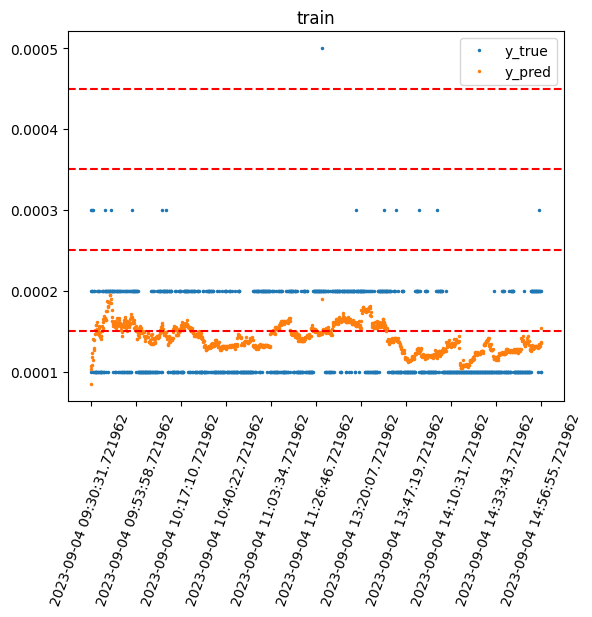

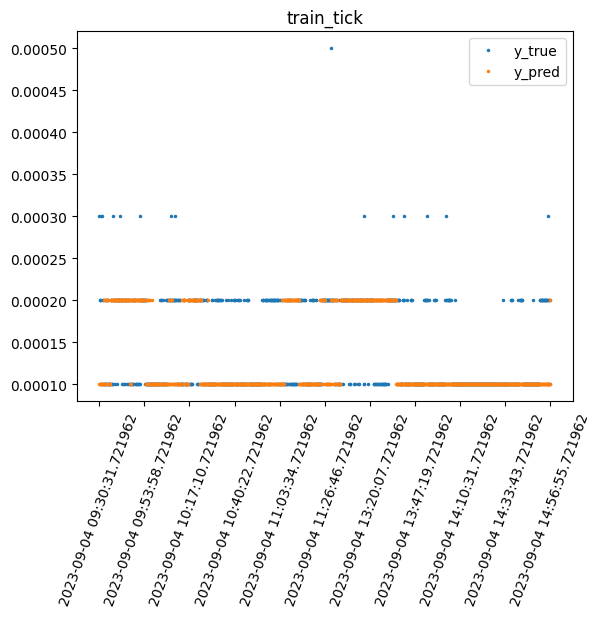

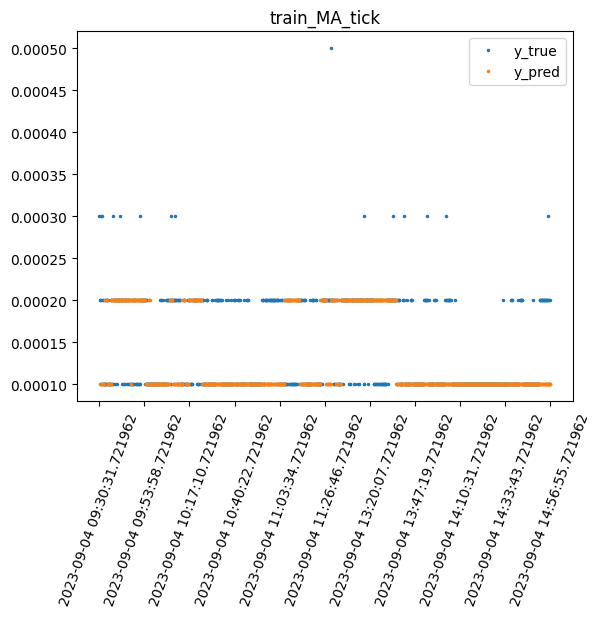

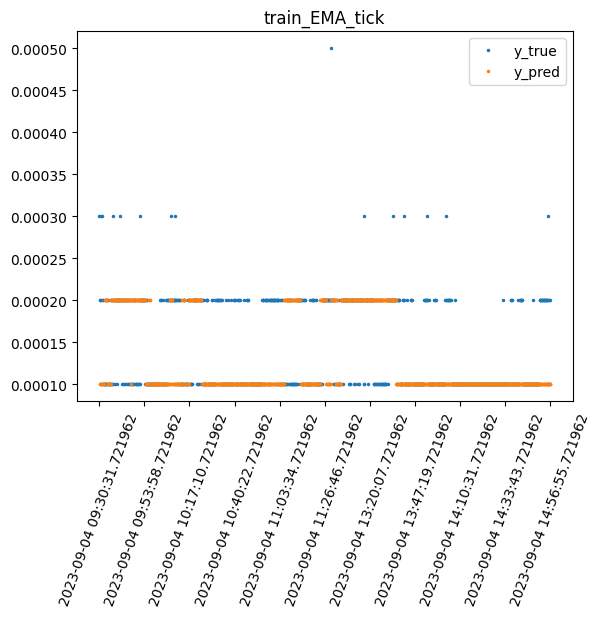

{'acc': 0.6727703576044808,
 'SSE': 1.1363139484417756e-05,
 'SSE_rounded': 1.6300000000000037e-05,
 'r2': 0.0982424706079631}

In [204]:
ss.plot_all(y_train, y_pred_train, name='train', window=10)
ss.gen_stat(y_train, y_pred_train)

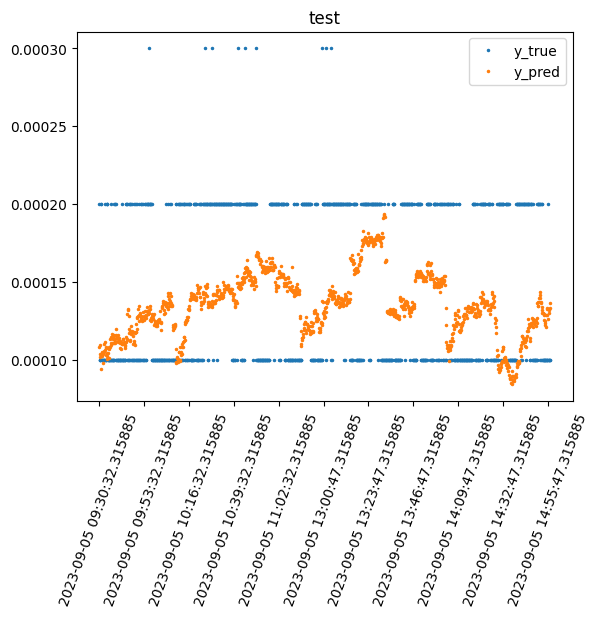

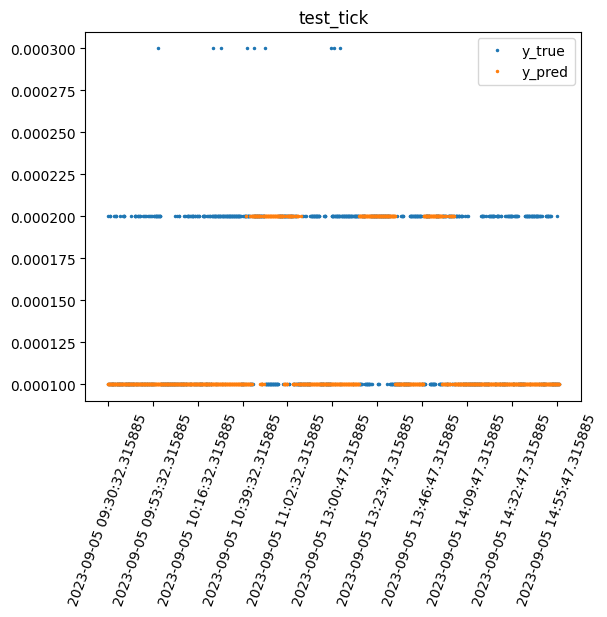

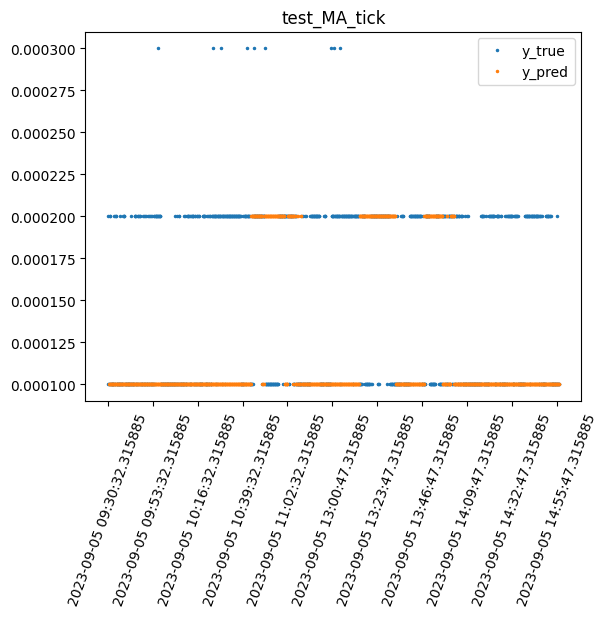

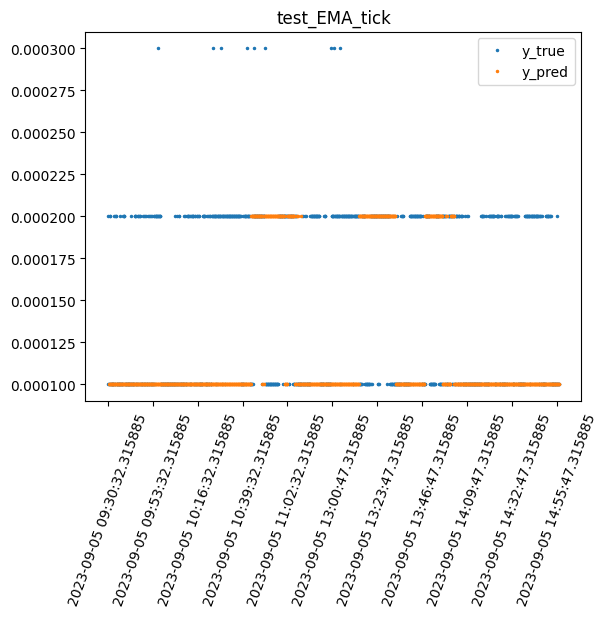

In [148]:
ss.plot_all(y_test, y_pred_test, name='test', window=10)
ss.gen_stat(y_test, y_pred_test)

### 统计特征的稳定性

In [ ]:
mean = Xy.mean()
std = Xy.std()
Xy = (Xy - mean) / std

In [208]:
Xy = Xy.drop(columns=['date'])

```
IV                      -0.3054      0.038     -8.134      0.000      -0.379      -0.232
avg_duration          3.375e-07      2e-08     16.904      0.000    2.98e-07    3.77e-07
const                    0.0337      0.004      8.067      0.000       0.026       0.042
delta                    0.1044      0.015      6.989      0.000       0.075       0.134
etf_quoted_spread        0.0128      0.013      1.007      0.314      -0.012       0.038
future_quoted_spread     0.0158      0.007      2.105      0.035       UPPER_BOUND       0.030
is_opening_period      2.25e-15   2.77e-16      8.132      0.000    1.71e-15    2.79e-15
mid_quoted_price         0.0342      0.045      0.764      0.445      -0.054       0.122
moneyness_delta         -4.2267      0.527     -8.014      0.000      -5.261      -3.193
moneyness_squared        3.5534      0.441      8.067      0.000       2.690       4.417
moneyness_t2m           -2.5711      0.322     -7.993      0.000      -3.202      -1.940
opening_decreasing            0          0        nan        nan           0           0
```

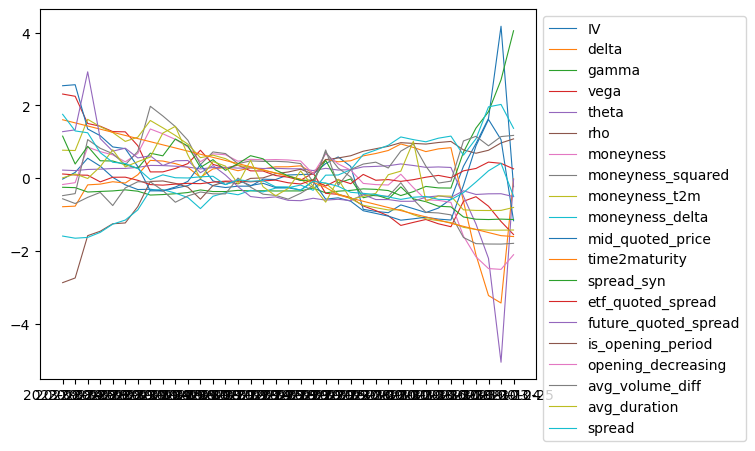

In [209]:

Xy['date'] = Xy.index.date
plot_legend_outside(Xy.groupby('date').mean(), shrink=30)


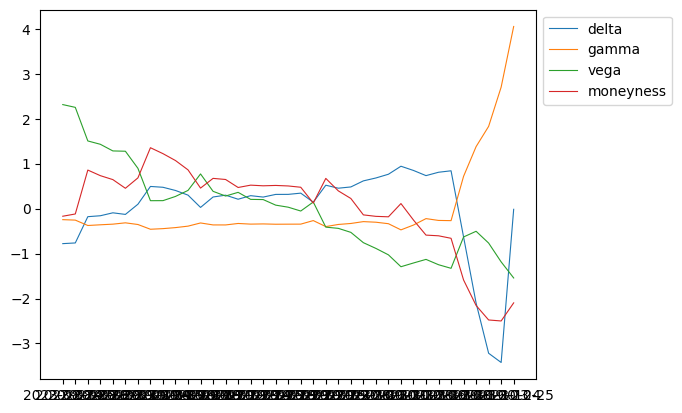

In [211]:
plot_legend_outside(Xy.groupby('date').mean()[['delta', 'gamma', 'vega', 'moneyness']])


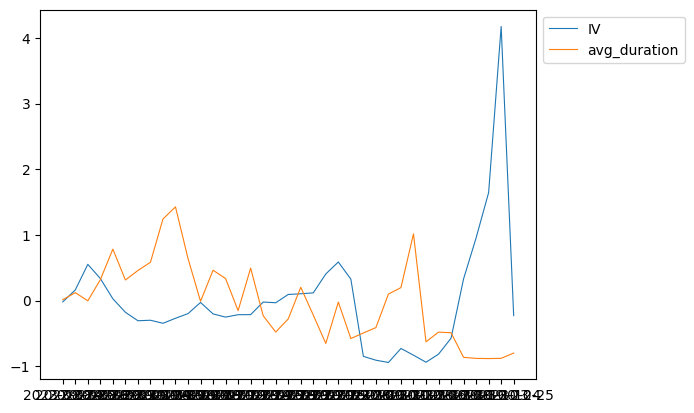

In [214]:
plot_legend_outside(Xy.groupby('date').mean()[['IV', 'avg_duration']])


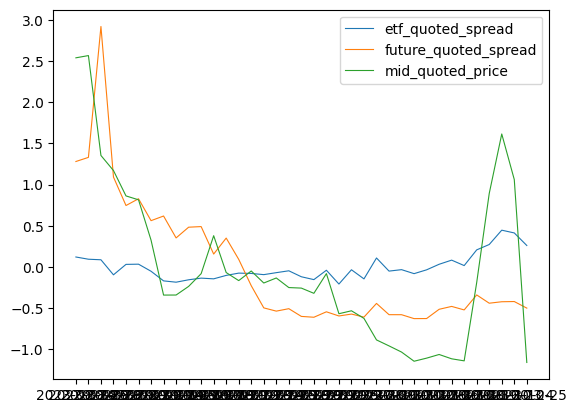

In [215]:

plot_legend_outside(Xy.groupby('date').mean()[['etf_quoted_spread', 'future_quoted_spread', 'mid_quoted_price']])


### loop for single contract

In [252]:
def replace_outliers(ser, threshold=UPPER_BOUND):
    idx = ser > threshold
    idx1 = ser < 0
    ser[np.logical_or(idx, idx1)] = np.nan
    return ser

In [253]:
y_col = 'spread'
exclude = [y_col, 'spread_syn', 'theta', 'rho', 'avg_volume_diff', 'mid_quoted_price', 'etf_quoted_spread',
           'opening_decreasing', 'is_opening_period', 'time2maturity', 'moneyness_delta', 'moneyness_squared']

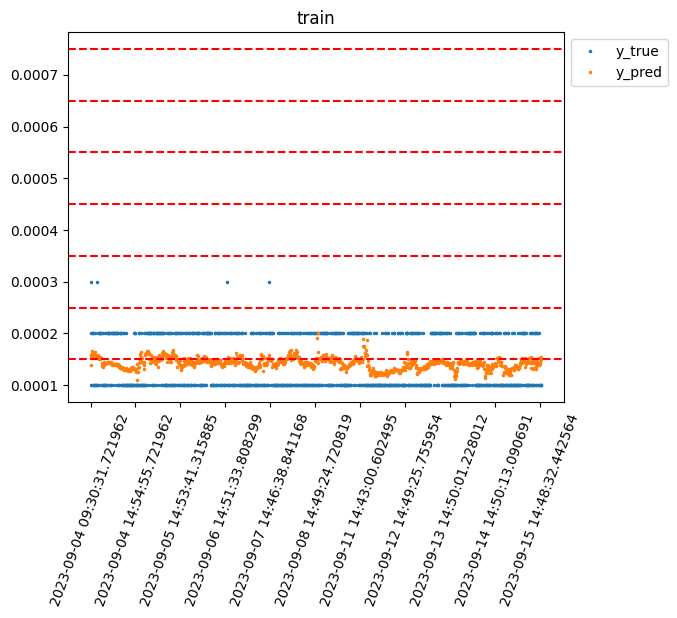

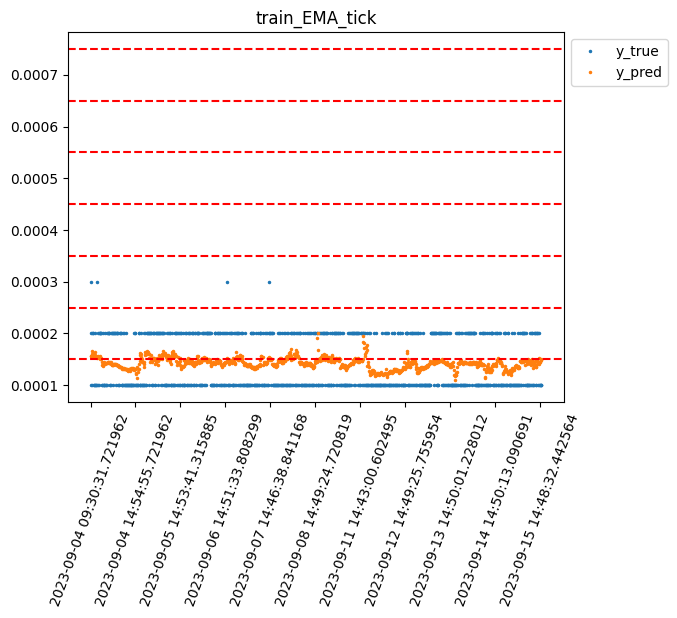

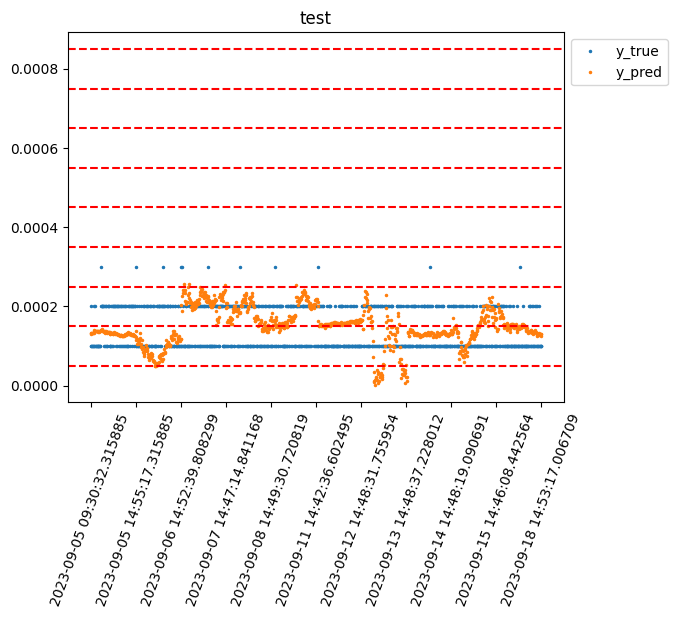

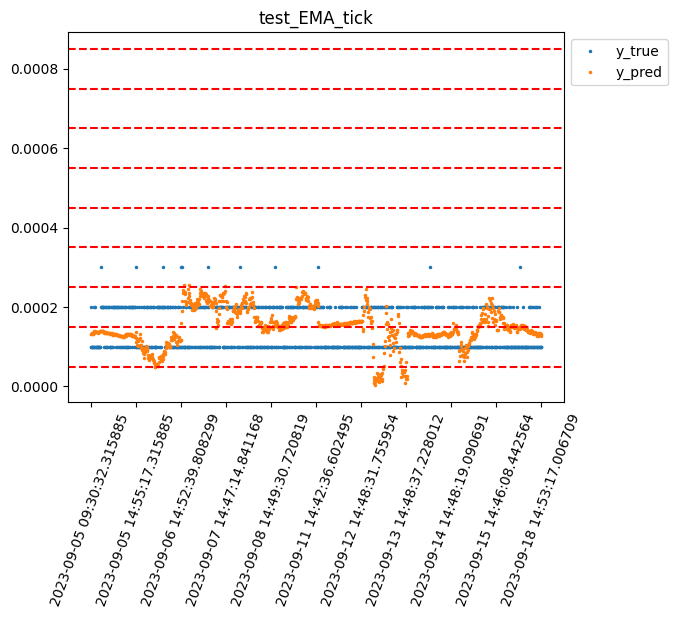

({'acc': 0.5952783192549275,
  'SSE': 0.00011794660124740166,
  'SSE_rounded': 0.00019589000000000008,
  'r2': 0.04313090552183818},
 {'acc': 0.4972485046220772,
  'SSE': 0.00021787899595298733,
  'SSE_rounded': 0.00026788000000000007,
  'r2': -0.7970642299234929})

In [261]:
date_idx = -30  # 距离到期日前n天
all_y_true_train = []
all_y_pred_train = []
all_y_true_test = []
all_y_pred_test = []
for date_idx in range(-30, -20, 1):
    # train data
    temp = deepcopy(Xy.loc[str(sorted(list(set(Xy.index.date)))[date_idx])])

    # X_train=temp.drop(columns=[y_col,])
    # X_train = temp.drop(columns=exclude)
    X_train = temp[['delta', 'vega', 'gamma', 'moneyness', 'future_quoted_spread']]

    X_train = sm.add_constant(X_train, has_constant='skip')
    y_train = temp[y_col]

    # test data
    temp = deepcopy(Xy.loc[str(sorted(list(set(Xy.index.date)))[date_idx + 1])])

    # X_test=temp.drop(columns=[y_col,])
    #     X_test = temp.drop(columns=exclude)
    X_test = temp[['delta', 'vega', 'gamma', 'moneyness', 'future_quoted_spread']]

    X_test = sm.add_constant(X_test, has_constant='skip')
    y_test = temp[y_col]

    # note: test和train对齐
    usecols = sorted(list(set(X_train.columns).intersection(set(X_test.columns))))
    X_train = X_train.loc[:, usecols]
    X_test = X_test.loc[:, usecols]

    model = OLS(y_train, exog=X_train, missing='drop')
    results = model.fit()
    y_pred_train = model.predict(params=results.params, exog=X_train)
    y_pred_test = model.predict(params=results.params, exog=X_test)
    y_pred_train = pd.Series(data=y_pred_train, index=y_train.index, name='y_pred_train')
    y_pred_test = pd.Series(data=y_pred_test, index=y_test.index, name='y_pred_test')

    all_y_true_train.append(y_train)
    all_y_pred_train.append(y_pred_train)
    all_y_true_test.append(y_test)
    all_y_pred_test.append(y_pred_test)

all_y_true_train = pd.concat(all_y_true_train, axis=0)
all_y_pred_train = pd.concat(all_y_pred_train, axis=0)
all_y_true_test = pd.concat(all_y_true_test, axis=0)
all_y_pred_test = pd.concat(all_y_pred_test, axis=0)

all_y_true_train = replace_outliers(all_y_true_train, threshold=UPPER_BOUND)
all_y_pred_train = replace_outliers(all_y_pred_train, threshold=UPPER_BOUND)
all_y_true_test = replace_outliers(all_y_true_test, threshold=UPPER_BOUND)
all_y_pred_test = replace_outliers(all_y_pred_test, threshold=UPPER_BOUND)

ss.plot_all(all_y_true_train, all_y_pred_train, name='train', window=10)
ss.plot_all(all_y_true_test, all_y_pred_test, name='test', window=10)
ss.gen_stat(all_y_true_train, all_y_pred_train), ss.gen_stat(all_y_true_test, all_y_pred_test)

In [262]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 spread   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     34.63
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           7.19e-35
Time:                        15:26:10   Log-Likelihood:                 39450.
No. Observations:                4634   AIC:                        -7.889e+04
Df Residuals:                    4628   BIC:                        -7.885e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0049 

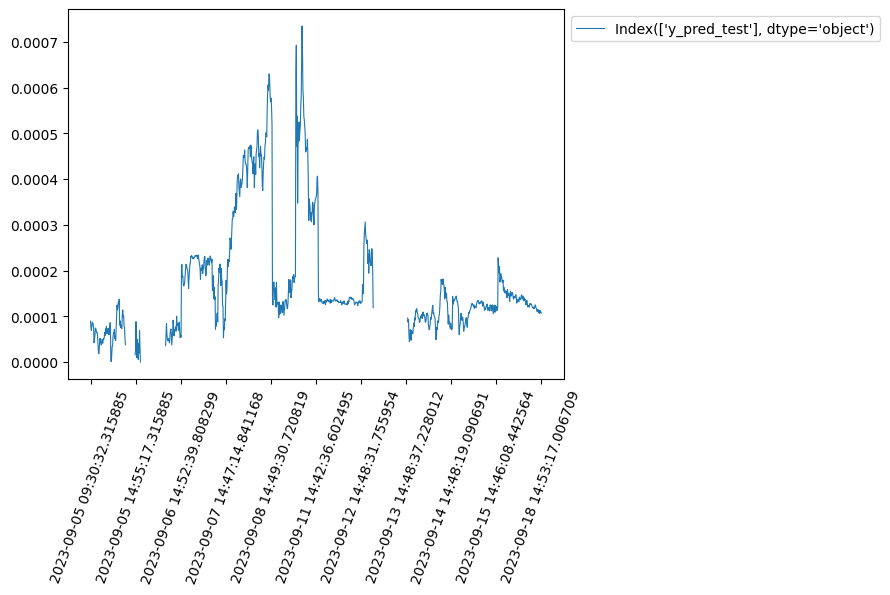

In [243]:
plot_legend_outside(all_y_pred_test)

### loop for multi contracts

需要注意不能是不同的期权方向和mat

In [265]:

get_contract(expire_date='2023-10-25', option_type='p', strike=None, underlying_symbol='510050.XSHG')

,trading_code,name,contract_type,exchange_code,currency_id,underlying_symbol,underlying_name,underlying_exchange,underlying_type,exercise_price,...,list_price,high_limit,low_limit,expire_date,last_trade_date,exercise_date,delivery_date,is_adjust,delist_date,delist_reason
code,,,,,,,,,,,,,,,,,,,,,
10005922,510050P2310M02350,50ETF沽10月2350,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.35,...,0.0183,0.2348,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005923,510050P2310M02400,50ETF沽10月2400,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.40,...,0.0230,0.2495,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005924,510050P2310M02450,50ETF沽10月2450,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.45,...,0.0381,0.2746,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005925,510050P2310M02500,50ETF沽10月2500,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.50,...,0.0555,0.3020,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005926,510050P2310M02550,50ETF沽10月2550,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.55,...,0.0790,0.3325,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005927,510050P2310M02600,50ETF沽10月2600,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.60,...,0.1064,0.3599,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005928,510050P2310M02650,50ETF沽10月2650,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.65,...,0.1397,0.3932,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005929,510050P2310M02700,50ETF沽10月2700,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.70,...,0.1806,0.4341,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期
10005930,510050P2310M02750,50ETF沽10月2750,PO,XSHG,CNY,510050.XSHG,50ETF,XSHG,ETF,2.75,...,0.2224,0.4759,0.0001,2023-10-25,2023-10-25,2023-10-25,2023-10-26,0,2023-10-26,合约到期


In [267]:
target = '510050P2310M02500'
Xy_train = pd.DataFrame()
Xy_test = pd.DataFrame()
for option_trading_code in ['510050P2310M02450', '510050P2310M02500', '510050P2310M02550']:
    _Xy = get_option_life(option_trading_code)
    _Xy = pd.concat(list(_Xy.values()), axis=0)
    Xy_train = pd.concat([Xy_train, _Xy], axis=0)
    if option_trading_code == target:
        Xy_test = deepcopy(_Xy)
Xy_train = Xy_train.sort_index()
Xy_test = Xy_test.sort_index()

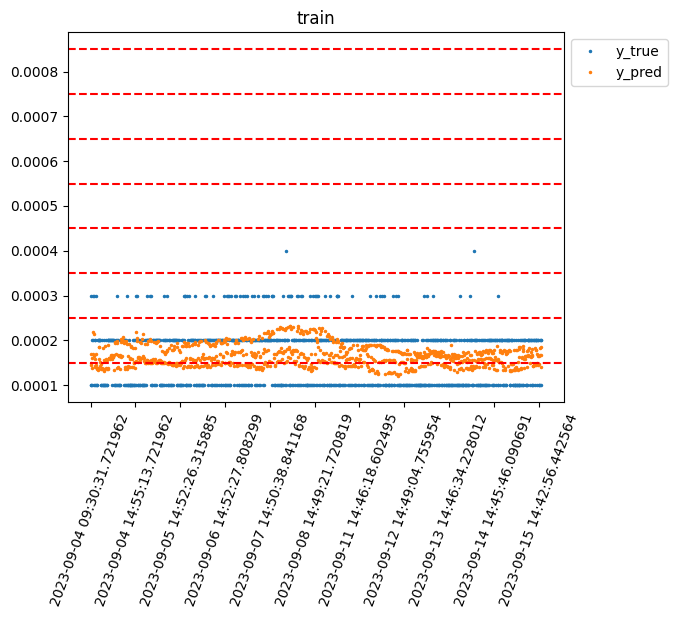

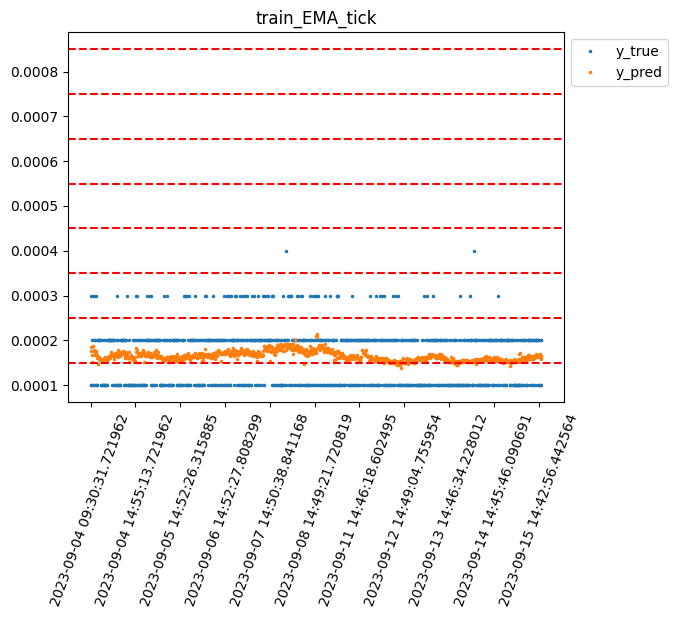

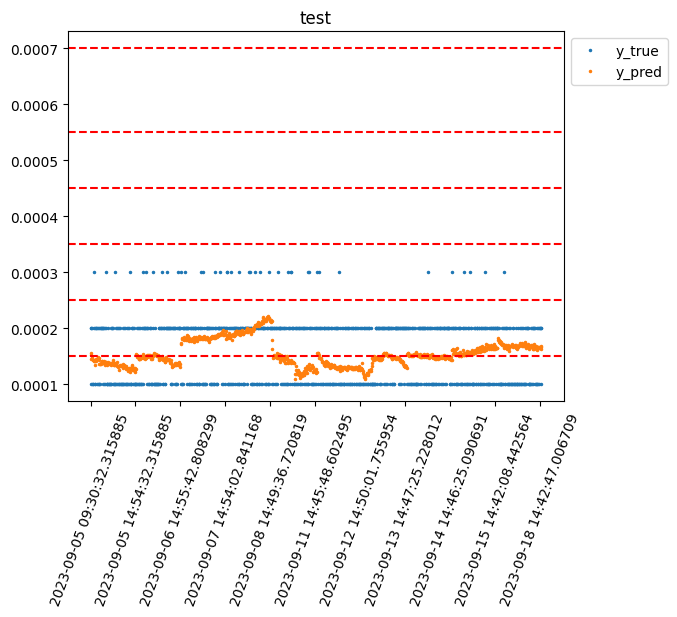

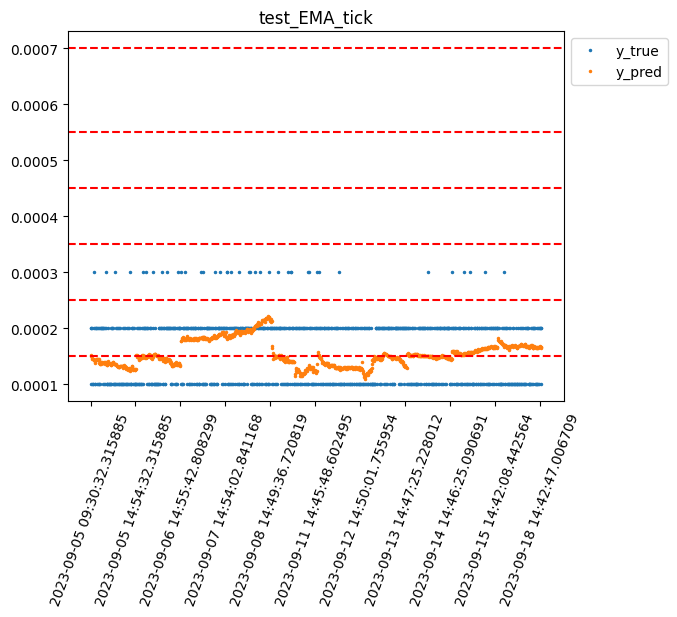

({'acc': 0.5550331918598324,
  'SSE': 0.0004721792207183836,
  'SSE_rounded': 0.0006389800000000003,
  'r2': 0.13729901415097268},
 {'acc': 0.4734951371243319,
  'SSE': 0.000172445896112819,
  'SSE_rounded': 0.00026927000000000006,
  'r2': -0.11870326167980538})

In [270]:
y_col = 'spread'
exclude = [y_col, 'spread_syn', 'theta', 'rho', 'avg_volume_diff', 'mid_quoted_price', 'etf_quoted_spread',
           'opening_decreasing', 'is_opening_period', 'time2maturity', 'moneyness_delta', 'moneyness_squared']
date_idx = -30  # 距离到期日前n天
all_y_true_train = []
all_y_pred_train = []
all_y_true_test = []
all_y_pred_test = []
all_stats = {}
for date_idx in range(-30, -20, 1):
    usecols = ['delta', 'vega', 'gamma', 'moneyness', 'future_quoted_spread']
    usecols = list(set(usecols) - set(exclude))

    # train data
    temp = deepcopy(Xy_train.loc[str(sorted(list(set(Xy_train.index.date)))[date_idx])])
    X_train = temp[usecols]
    X_train = sm.add_constant(X_train, has_constant='skip')
    y_train = temp[y_col]

    # test data
    temp = deepcopy(Xy_test.loc[str(sorted(list(set(Xy_test.index.date)))[date_idx + 1])])
    X_test = temp[usecols]
    X_test = sm.add_constant(X_test, has_constant='skip')
    y_test = temp[y_col]

    # note: test和train对齐，主要是为了防止某一个有const
    usecols = sorted(list(set(X_train.columns).intersection(set(X_test.columns))))
    X_train = X_train.loc[:, usecols]
    X_test = X_test.loc[:, usecols]

    model = OLS(y_train, exog=X_train, missing='drop')
    results = model.fit()
    y_pred_train = model.predict(params=results.params, exog=X_train)
    y_pred_test = model.predict(params=results.params, exog=X_test)
    y_pred_train = pd.Series(data=y_pred_train, index=y_train.index, name='y_pred_train')
    y_pred_test = pd.Series(data=y_pred_test, index=y_test.index, name='y_pred_test')

    all_y_true_train.append(y_train)
    all_y_pred_train.append(y_pred_train)
    all_y_true_test.append(y_test)
    all_y_pred_test.append(y_pred_test)

all_y_true_train = pd.concat(all_y_true_train, axis=0)
all_y_pred_train = pd.concat(all_y_pred_train, axis=0)
all_y_true_test = pd.concat(all_y_true_test, axis=0)
all_y_pred_test = pd.concat(all_y_pred_test, axis=0)

all_y_true_train = replace_outliers(all_y_true_train, threshold=UPPER_BOUND)
all_y_pred_train = replace_outliers(all_y_pred_train, threshold=UPPER_BOUND)
all_y_true_test = replace_outliers(all_y_true_test, threshold=UPPER_BOUND)
all_y_pred_test = replace_outliers(all_y_pred_test, threshold=UPPER_BOUND)

ss.plot_all(all_y_true_train, all_y_pred_train, name='train', window=10)
ss.plot_all(all_y_true_test, all_y_pred_test, name='test', window=10)
ss.gen_stat(all_y_true_train, all_y_pred_train), ss.gen_stat(all_y_true_test, all_y_pred_test)

# 查看某一天不同期权合约spread结构

In [440]:
import math
from typing import Union

import pyecharts.options as opts
from pyecharts.charts import Surface3D


## 同一天同mat不同strike

In [285]:
option_underlying_symbol = '510050.XSHG'
option_type = 'p'
expire_date = '2023-10-25'
# get_contract(expire_date=expire_date, option_type=option_type, strike=None, underlying_symbol=option_underlying_symbol) # '2023-09-27', '2023-10-25'

In [276]:
Xy_dict = {}  # {option trading code: Xy}
for option_trading_code in ['510050P2310M02450', '510050P2310M02500', '510050P2310M02550']:
    _Xy = get_option_life(option_trading_code)
    _Xy = pd.concat(list(_Xy.values()), axis=0).sort_index()
    Xy_dict[option_trading_code] = _Xy


In [446]:
title = option_trading_code[:11]
res = {}
for date_ in dates_list[20:21]:
    for k, v in Xy_dict.items():
        idx = v.index.date.astype(str) == date_
        res[int(k[-5:]) / 1000] = v.loc[idx, 'spread']

    break
res = pd.DataFrame(res).ffill()
res.index=pd.to_datetime(res.index)

In [485]:
res=tp.del_untrade_time_(res,strip=['5m','1m','1m','5m'])

In [486]:


def plottable_3d_info(df: pd.DataFrame, shrink=True):
    """
    Transform Pandas data into a format that's compatible with
    Matplotlib's surface and wireframe plotting.
    """

    df = df.clip(upper=0.01)

    index = df.index
    columns = df.columns

    x, y = np.meshgrid(np.arange(len(columns)), np.arange(len(index)))
    z = np.array([[df[c][i] for c in columns] for i in index])

    xticks = dict(ticks=np.arange(len(columns)), labels=columns)

    length = len(index)
    steps = 5
    step = length // steps

    if shrink:
        yticks = dict(ticks=np.arange(len(index))[::step], labels=index[::step])
    else:
        yticks = dict(ticks=np.arange(len(index)), labels=index)

    return x, y, z, xticks, yticks, step


In [487]:

x, y, z, xticks, yticks, step = plottable_3d_info(res.iloc[::100], shrink=False)
data = [list(t) for t in list(zip([xticks['labels'][xx] for xx in x.flatten()], [yticks['labels'].astype(str)[yy][:-7] for yy in y.flatten()], z.flatten().round(decimals=DECIMALS)))]

(
    Surface3D()
    .add(
        series_name=title,
        shading="color",
        data=data,
        xaxis3d_opts=opts.Axis3DOpts(type_="category", name='strike',
                                     # min_=min(xticks['labels']),max_=max(xticks['labels'])
                                     ),
        yaxis3d_opts=opts.Axis3DOpts(
            type_="category", name='datetime',
        ),
        zaxis3d_opts=opts.Axis3DOpts(
            type_="value", name='spread',
            min_=TICK_SIZE,
            max_=UPPER_BOUND
        ),
        grid3d_opts=opts.Grid3DOpts(
            is_show=True,
            width=100, height=40, depth=200,
            axislabel_opts=opts.LabelOpts(
                font_size=12,
                font_family='Times New Roman',
            ),
        ),        
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            dimension=2,
            max_=UPPER_BOUND,
            min_=0,
            range_color=[
                "#313695",
                "#4575b4",
                "#74add1",
                "#abd9e9",
                "#e0f3f8",
                "#ffffbf",
                "#fee090",
                "#fdae61",
                "#f46d43",
                "#d73027",
                "#a50026",
            ],
            split_number=10,
            precision=4,
        ),
        title_opts=opts.TitleOpts(title=title,),
    )
    .render(res_root + "plots/surface_wave.html")
)


'/Users/hongyifan/Desktop/work/internship/citic_futures/20231226bid-ask-spread/res/plots/surface_wave.html'

## 同一天同strike不同mat

# todo Robust regression

# check errors

In [422]:
with open(data_root + f"error_dicts/error_dict_2023-08-17_2023-08-22.pkl", 'rb') as fr:
    error_dict = pickle.load(fr)
error_dict

defaultdict(dict,
            {'2023-08-21': {('510050P2308M02350',
               1,
               'PO',
               2.35): IndexError('single positional indexer is out-of-bounds')},
             '2023-08-22': {('510050P2308M02350',
               1,
               'PO',
               2.35): IndexError('single positional indexer is out-of-bounds'),
              ('510050P2308M02400',
               1,
               'PO',
               2.4): IndexError('single positional indexer is out-of-bounds'),
              ('510300P2308M03500',
               1,
               'PO',
               3.5): IndexError('single positional indexer is out-of-bounds'),
              ('510300C2308M04400',
               1,
               'CO',
               4.4): IndexError('single positional indexer is out-of-bounds'),
              ('510300P2308M03400',
               1,
               'PO',
               3.4): IndexError('single positional indexer is out-of-bounds')}})

In [425]:
e = list(list(error_dict.values())[0].values())[0]

In [428]:
e.__traceback__

# 保存

In [265]:
if not os.path.exists(model_root):
    os.mkdir(model_root)
with open(model_root + f"{get_class_name(results)}_{'2023-08-01'}.pkl", 'wb') as fw:
    pickle.dump(results, fw)

In [229]:
model_params = results.params